In [1]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', None)

<h2>Import Data</h2>

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.drop('id', axis=1, inplace=True)
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

<h2>Handle NaN</h2>

In [3]:
#df = df.dropna(how='any')
df = df.fillna(df.mean())
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


<h2>Normalization</h2>

In [4]:
columns = ["age", "avg_glucose_level", "bmi"]

for column in columns:
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,0.816895,0,1,Yes,Private,Urban,0.801265,0.301260,formerly smoked,1
1,Female,0.743652,0,0,Yes,Self-employed,Rural,0.679023,0.212981,never smoked,1
2,Male,0.975586,0,1,Yes,Private,Rural,0.234512,0.254296,never smoked,1
3,Female,0.597168,0,0,Yes,Private,Urban,0.536008,0.276060,smokes,1
4,Female,0.963379,1,0,Yes,Self-employed,Rural,0.549349,0.156930,never smoked,1


<h2>One-Hot Encoding</h2>

In [5]:
cleanup = {
    "hypertension": {
        0: "no",
        1: "yes"
    },
    "heart_disease": {
        0: "no",
        1: "yes"
    }
}

In [6]:
df = df.replace(cleanup)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,0.816895,no,yes,Yes,Private,Urban,0.801265,0.301260,formerly smoked,1
1,Female,0.743652,no,no,Yes,Self-employed,Rural,0.679023,0.212981,never smoked,1
2,Male,0.975586,no,yes,Yes,Private,Rural,0.234512,0.254296,never smoked,1
3,Female,0.597168,no,no,Yes,Private,Urban,0.536008,0.276060,smokes,1
4,Female,0.963379,yes,no,Yes,Self-employed,Rural,0.549349,0.156930,never smoked,1


In [7]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,age,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,hypertension_yes,heart_disease_yes,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.816895,0.801265,0.301260,1,1,0,0,1,1,0,1,0,0,1,1,0,0
1,0.743652,0.679023,0.212981,1,0,0,0,0,1,0,0,1,0,0,0,1,0
2,0.975586,0.234512,0.254296,1,1,0,0,1,1,0,1,0,0,0,0,1,0
3,0.597168,0.536008,0.276060,1,0,0,0,0,1,0,1,0,0,1,0,0,1
4,0.963379,0.549349,0.156930,1,0,0,1,0,1,0,0,1,0,0,0,1,0


## Balancing the Dataset

In [8]:
train = df.sample(frac=0.8, random_state=1)
test = df.drop(train.index, )

In [9]:
train['stroke'].value_counts()

0    3889
1     199
Name: stroke, dtype: int64

In [10]:
test['stroke'].value_counts()

0    972
1     50
Name: stroke, dtype: int64

In [11]:
columns = df.columns.to_list()[ 4 : ]
columns

['gender_Male',
 'gender_Other',
 'hypertension_yes',
 'heart_disease_yes',
 'ever_married_Yes',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes']

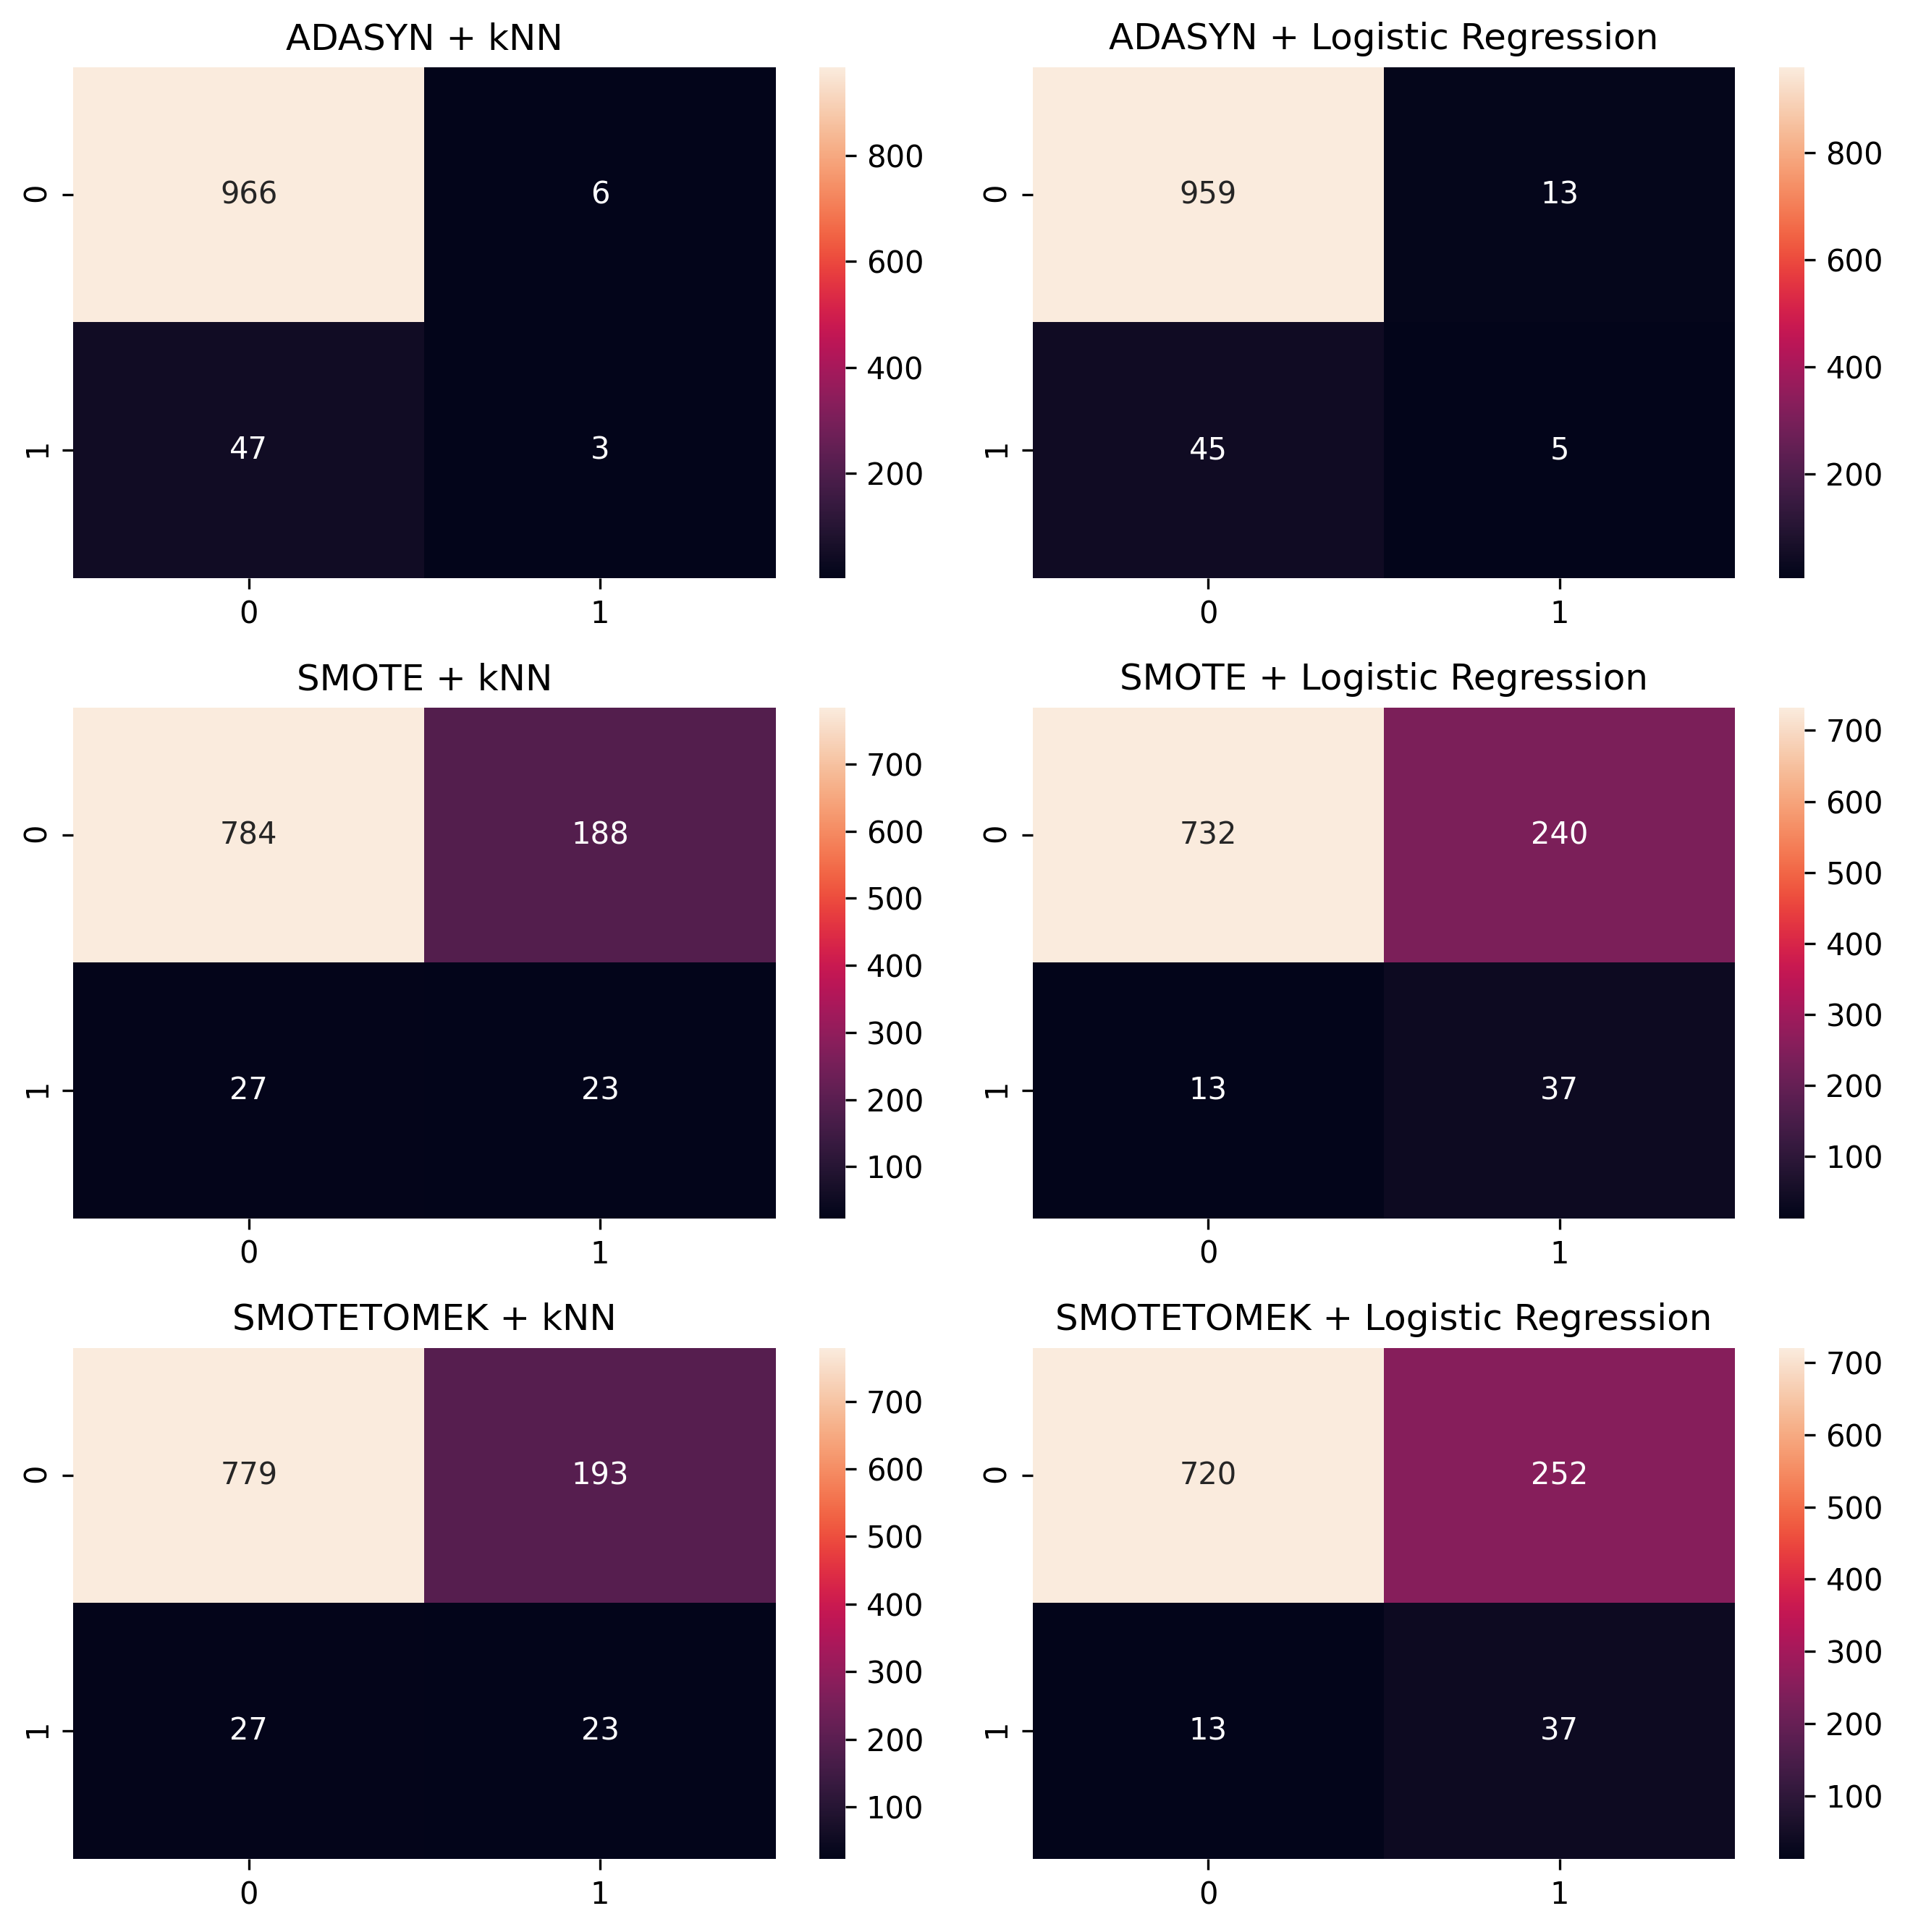

In [12]:
from crucio import ADASYN, SMOTE, SMOTETOMEK
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

algorithms = [ADASYN, SMOTE, SMOTETOMEK]
titles = ['ADASYN', 'SMOTE', 'SMOTETOMEK']

fig = plt.figure(figsize=(9, 9), dpi=300)

y_test = test['stroke']
X_test = test.drop('stroke', axis=1)

for index, algorithm in enumerate(algorithms):
    a = algorithm(binary_columns=columns)
    t = a.balance(train, 'stroke')
    y_train = t['stroke']
    X_train = t.drop('stroke', axis=1)

    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    ax = fig.add_subplot(320 + index*2 + 1)
    sns.heatmap(
        confusion_matrix(y_test, y_pred), 
        annot=True, fmt='g', ax=ax
    ).set_title(titles[index] + ' + kNN')

    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    ax = fig.add_subplot(320 + index*2 + 2)
    sns.heatmap(
        confusion_matrix(y_test, y_pred), 
        annot=True, fmt='g', ax=ax
    ).set_title(titles[index] + ' + Logistic Regression')

plt.tight_layout()

Based on these confusion matrices I believe that SMOTE \+ Logistic Regression did the best job.